In [27]:
# Importing Necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from transformers import  TFBertForSequenceClassification, BertTokenizer
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Data Preparation

In [3]:
#Loading the train data
train_data=pd.read_csv('train.csv')
train_data.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24491034,24491034_0_11,The emergence of HIV as a chronic condition me...,0,11,0_11,BACKGROUND
1,24491034,24491034_1_11,This paper describes the design and evaluation...,1,11,1_11,BACKGROUND
2,24491034,24491034_2_11,This study is designed as a randomised control...,2,11,2_11,METHODS
3,24491034,24491034_3_11,The intervention group will participate in the...,3,11,3_11,METHODS
4,24491034,24491034_4_11,The program is based on self-efficacy theory a...,4,11,4_11,METHODS


In [4]:
#Loading the test data
test_data=pd.read_csv('test.csv')
test_data.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24562799,24562799_0_11,Many pathogenic processes and diseases are the...,0,11,0_11,BACKGROUND
1,24562799,24562799_1_11,It was recently demonstrated that supraphysiol...,1,11,1_11,BACKGROUND
2,24562799,24562799_2_11,"In the present study , we examined the associa...",2,11,2_11,BACKGROUND
3,24562799,24562799_3_11,"In addition , we compared plasma levels of MAp...",3,11,3_11,BACKGROUND
4,24562799,24562799_4_11,A total of 192 MI patients and 140 control per...,4,11,4_11,METHODS


In [5]:
#Loading the validation data
val_data=pd.read_csv('val.csv')
val_data.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,15337700,15337700_0_9,Adrenergic activation is thought to be an impo...,0,9,0_9,BACKGROUND
1,15337700,15337700_1_9,Systemic venous norepinephrine was measured at...,1,9,1_9,RESULTS
2,15337700,15337700_2_9,Baseline norepinephrine level was associated w...,2,9,2_9,RESULTS
3,15337700,15337700_3_9,"On multivariate analysis , baseline norepineph...",3,9,3_9,RESULTS
4,15337700,15337700_4_9,"In contrast , the relation of the change in no...",4,9,4_9,RESULTS


In [6]:
# Function for Pre-processing the data
stop_words = set(stopwords.words('english'))
# Function to preprocess text
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Removing stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [7]:
# Applying pre-processing to the abstract_text column
train_data['processed_text'] = train_data['abstract_text'].apply(preprocess_text)
test_data['processed_text'] = test_data['abstract_text'].apply(preprocess_text)
val_data['processed_text'] = val_data['abstract_text'].apply(preprocess_text)

In [8]:
# Distribution of labels in training data,validation and test data
train_unique_values = train_data['target'].unique()
print("Unique values in train 'target' column:", train_unique_values)
print(train_data.target.value_counts())
print("****************************************")
test_unique_values = test_data['target'].unique()
print("Unique values in Test 'target' column:", test_unique_values)
print(test_data.target.value_counts())
print("****************************************")
val_unique_values = train_data['target'].unique()
print("Unique values in Validation 'target' column:", val_unique_values)
print(val_data.target.value_counts())

Unique values in train 'target' column: ['BACKGROUND' 'METHODS' 'CONCLUSIONS' 'RESULTS' 'OBJECTIVE']
target
RESULTS        27811
METHODS        26172
CONCLUSIONS    12189
BACKGROUND      7072
OBJECTIVE       6756
Name: count, dtype: int64
****************************************
Unique values in Test 'target' column: ['BACKGROUND' 'METHODS' 'RESULTS' 'CONCLUSIONS' 'OBJECTIVE']
target
RESULTS        10276
METHODS         9751
CONCLUSIONS     4426
BACKGROUND      2663
OBJECTIVE       2377
Name: count, dtype: int64
****************************************
Unique values in Validation 'target' column: ['BACKGROUND' 'METHODS' 'CONCLUSIONS' 'RESULTS' 'OBJECTIVE']
target
RESULTS        9977
METHODS        9559
CONCLUSIONS    4396
BACKGROUND     2575
OBJECTIVE      2425
Name: count, dtype: int64


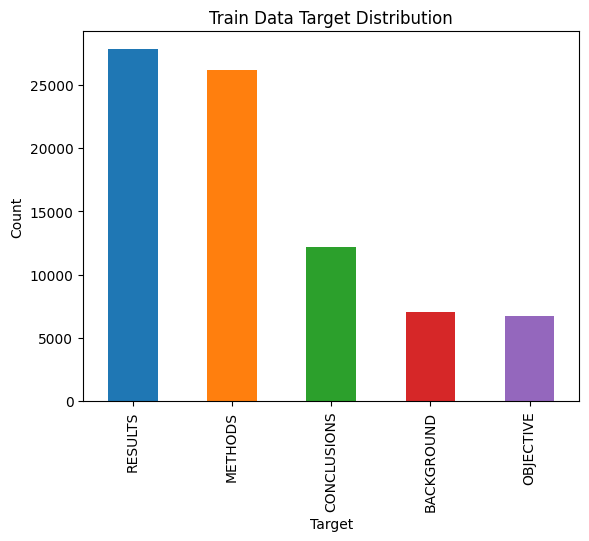

In [9]:
# Distribution of labels in training data
colors = plt.cm.tab10(range(len(train_unique_values)))
train_data['target'].value_counts().plot(kind='bar',color=colors)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Train Data Target Distribution')
plt.show()

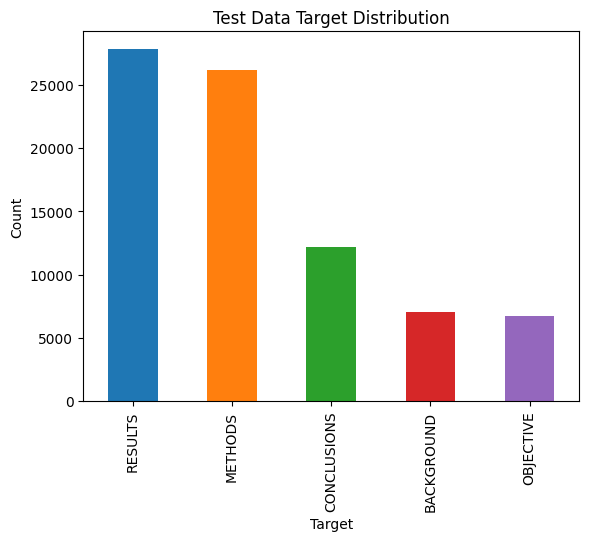

In [10]:
# Distribution of labels in Test data
colors = plt.cm.tab10(range(len(test_unique_values)))
train_data['target'].value_counts().plot(kind='bar',color=colors)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Test Data Target Distribution')
plt.show()

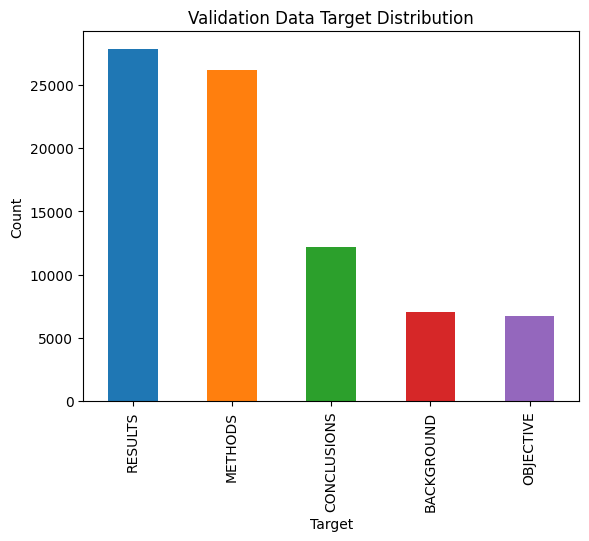

In [11]:
# Distribution of labels in Validation data
colors = plt.cm.tab10(range(len(val_unique_values)))
train_data['target'].value_counts().plot(kind='bar',color=colors)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Validation Data Target Distribution')
plt.show()

In [12]:
#Label Encoding 
y_train=np.array(train_data['target'].tolist())
y_val=np.array(val_data['target'].tolist())
y_test=np.array(test_data['target'].tolist())
labelencoder=LabelEncoder()
y_train=to_categorical(labelencoder.fit_transform(y_train))
y_val=to_categorical(labelencoder.fit_transform(y_val))
y_test=to_categorical(labelencoder.fit_transform(y_test))

## 2.Model Implementation

In [68]:
# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Tokenizing the train and validation data
train_encodings = tokenizer(train_data['processed_text'].tolist(), truncation=True, padding=True, return_tensors='tf')
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))

val_encodings = tokenizer(val_data['processed_text'].tolist(), truncation=True, padding=True, return_tensors='tf')
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))

In [15]:
# Fine-tune the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Training the model on train and validation data
hist = model.fit(train_dataset.batch(70), validation_data=val_dataset.batch(70),epochs=3)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1714303973.068309     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1143/1143 [==============================] - 1715s 1s/step - loss: 9.0476 - accuracy: 0.3267 - val_loss: 9.1253 - val_accuracy: 0.3304
Epoch 2/3
1143/1143 [==============================] - 1607s 1s/step - loss: 9.0837 - accuracy: 0.3271 - val_loss: 9.1253 - val_accuracy: 0.3304
Epoch 3/3
1143/1143 [==============================] - 1606s 1s/step - loss: 9.0894 - accuracy: 0.3271 - val_loss: 9.1253 - val_accuracy: 0.3304


In [ ]:
# Evaluate on test data
test_encodings = tokenizer(test_data['processed_text'].tolist(), truncation=True, padding=True, return_tensors='tf')
test_outputs = model.predict(dict(test_encodings))
y_pred_classes=np.argmax(test_outputs[0],axis=1)
y_test=np.argmax(y_test,axis=1)

## 3. Evaluation

Accuracy: 33.06208252805751
F1 Score:0.1642994428351283
Confusion Matrix:


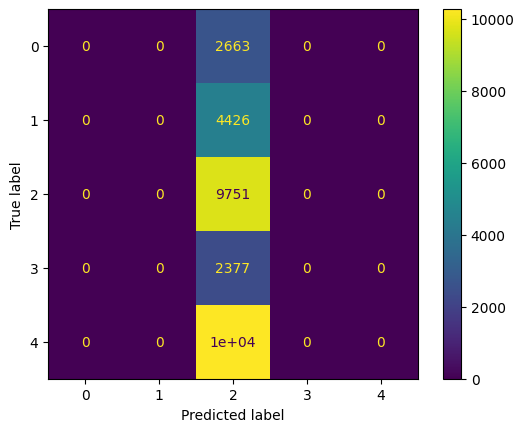

In [26]:
accuracy = accuracy_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes,labels=np.unique(y_test))
score = f1_score(y_test, y_pred_classes, average='weighted')
print(f'Accuracy: {accuracy *100}')
print(f'F1 Score:{score}')
print('Confusion Matrix:')
cm=ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=np.unique(y_test))
cm.plot()
plt.show()

### Accuracy is very low 33%
### F1 Score is 0.16 
### Training time and requirement of resources for training is huge
### Stability in Metrics: Both loss and accuracy metrics are quite stable across the epochs, with very minor changes.
### High Loss Values: The loss values are unusually high, which could indicate issues with the model, such as an inappropriate model architecture for the task.
### Low Accuracy: The accuracy is relatively low, suggesting the model is not performing well on the test dataset.
### Potential Overfitting: The model does not appear to overfit, given that the training and validation metrics are close, but overall performance is poor.

## 4. Discussion

### Here are a few key points on how transformer architecture benefits this specific task:

#### Parallel Processing: Unlike recurrent neural networks (RNNs), transformers do not process data sequentially. Instead, they handle entire sequences simultaneously. 

#### Attention Mechanism: At the core of the transformer architecture is the attention mechanism, which enables the model to focus on different parts of the input sequence when predicting each part of the output sequence. This is particularly useful in sentence classification as it allows the model to pay attention to the most relevant parts of a sentence or context that are crucial for determining the sentence's classification.

#### Scalability: Transformers are highly scalable with the ability to process very long sequences of data, thanks to self-attention. This scalability is crucial when dealing with large texts.

#### Transfer Learning: The transformer architecture has been foundational in the development of large pre-trained models like BERT and GPT. These models can be fine-tuned for specific tasks like sentence classification with relatively little additional training data, providing high performance even on tasks with limited labeled data.


### These characteristics make transformers particularly effective for tasks involving the classification of sentences, whether in determining sentiment, intent, or other categorical labels based on textual data.

In [55]:
# Tokenize and pad the Train data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['processed_text'])
train_sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
train_padded_sequences = pad_sequences(train_sequences, maxlen=200)

In [56]:
# Tokenize and pad the Test data
tokenizer.fit_on_texts(test_data['processed_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['processed_text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=200)

In [57]:
# Tokenize and pad the Validation data
tokenizer.fit_on_texts(val_data['processed_text'])
val_sequences = tokenizer.texts_to_sequences(val_data['processed_text'])
val_padded_sequences = pad_sequences(val_sequences, maxlen=200)

In [58]:
# Define baseline LSTM model
baseline_model = Sequential([
    Embedding(5000, 64, input_length=200),
    LSTM(64),
    Dense(5, activation='softmax')
])

In [59]:
# Train baseline model
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = baseline_model.fit(train_padded_sequences, y_train, epochs=50, validation_data=(val_padded_sequences,y_val))


Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.6619 - loss: 0.8514 - val_accuracy: 0.4220 - val_loss: 1.7114
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.7959 - loss: 0.5527 - val_accuracy: 0.4132 - val_loss: 1.8100
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8238 - loss: 0.4856 - val_accuracy: 0.4089 - val_loss: 1.8980
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8456 - loss: 0.4292 - val_accuracy: 0.4126 - val_loss: 1.9830
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8641 - loss: 0.3868 - val_accuracy: 0.4040 - val_loss: 2.1889
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8795 - loss: 0.3407 - val_accuracy: 0.4053 - val_loss: 2.3130
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8973 - loss: 0.2945 - val_accuracy: 0.3970 - val_loss: 2.5514
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.9108 -

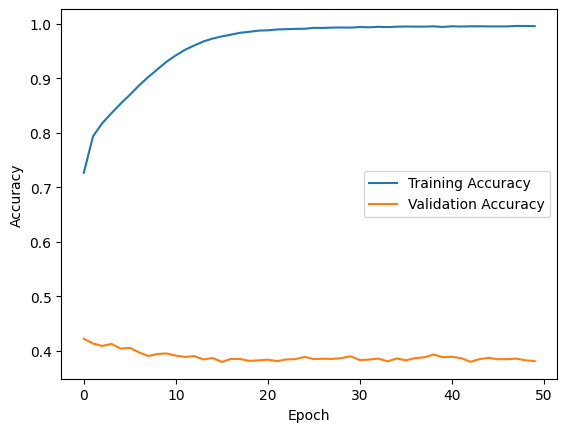

In [60]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

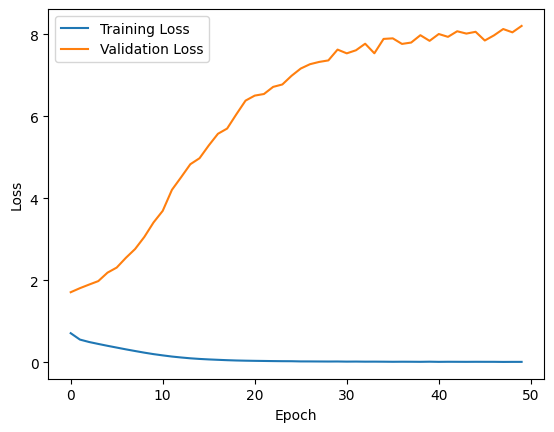

In [61]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
# Evaluate baseline model
baseline_preds = baseline_model.predict(test_padded_sequences)
baseline_preds = np.argmax(baseline_preds, axis=1)

922/922 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


Accuracy: 39.789102498898046
F1 Score:0.3853326485145011
Confusion Matrix:


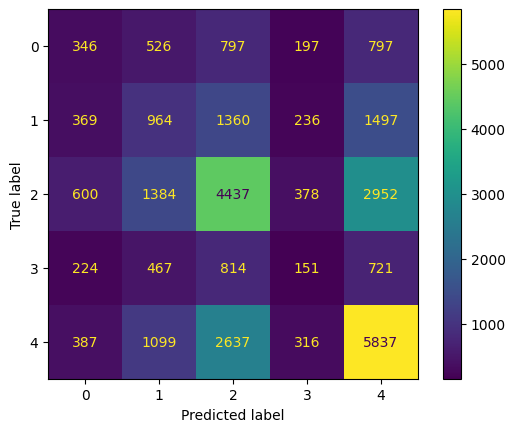

In [66]:
# Calculate metrics for baseline model
baseline_accuracy = accuracy_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds, average='weighted')
baseline_conf_matrix = confusion_matrix(y_test, baseline_preds,labels=np.unique(y_test))
print(f'Accuracy: {baseline_accuracy *100}')
print(f'F1 Score:{baseline_f1}')
print('Confusion Matrix:')
cm=ConfusionMatrixDisplay(confusion_matrix=baseline_conf_matrix,
                              display_labels=np.unique(y_test))
cm.plot()
plt.show()